In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import colour

20nm -> XYZ: [ 15.63391295  16.27497422  31.6241443 ], sRGB: [ 0.34712092  0.44539356  0.59242291]


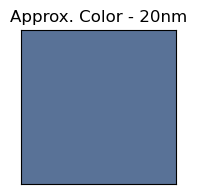

In [6]:
# === CONFIGURATION ===
folder_path = "C:/Users/kunal/Downloads/PS-packing-1step/"  # Change this path as needed
output_file = os.path.join(folder_path, "sRGB_D65_300.txt")  # Updated output file name
spectral_shape = colour.SpectralShape(360, 830, 1)

# === PREPARE COLOR SCIENCE ELEMENTS ===
illuminant = colour.SDS_ILLUMINANTS['D65'].copy().align(spectral_shape)
cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy().align(spectral_shape)
illuminant_XYZ = colour.sd_to_XYZ(illuminant, cmfs, illuminant)

# === INIT OUTPUT FILE ===
with open(output_file, "w") as f:
    f.write("Thickness (nm): R, G, B (sRGB in 0-1 range)\n")

# === GATHER MATCHING FILES ===
file_list = os.listdir(folder_path)
pattern = re.compile(r"PS_300nm(\d+)\.txt")

matched_files = []
for filename in file_list:
    match = pattern.match(filename)
    if match:
        thickness = int(match.group(1))
        matched_files.append((thickness, filename))

# === SORT BY THICKNESS ===
matched_files.sort()

# === PROCESS EACH FILE ===
for thickness, filename in matched_files:
    filepath = os.path.join(folder_path, filename)

    try:
        wavelengths, reflectance = np.loadtxt(filepath, delimiter=",", unpack=True)
    except:
        wavelengths, reflectance = np.loadtxt(filepath, unpack=True)  # fallback

    sd = colour.SpectralDistribution(dict(zip(wavelengths, reflectance)), name=filename)
    sd = sd.copy().align(spectral_shape)

    XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
    rgb = colour.XYZ_to_sRGB(XYZ / 100)  # Normalize XYZ for sRGB
    rgb_clipped = np.clip(rgb, 0, 1)

    # Append to output file
    with open(output_file, "a") as f:
        f.write(f"{thickness}nm: {rgb_clipped[0]:.8f}, {rgb_clipped[1]:.8f}, {rgb_clipped[2]:.8f}\n")

    # Optional preview at specific thickness
    if thickness == 20:
        print(f"{thickness}nm -> XYZ: {XYZ}, sRGB: {rgb_clipped}")
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.set_facecolor(rgb_clipped)
        ax.set_xticks([]); ax.set_yticks([])
        plt.title(f"Approx. Color - {thickness}nm")
        plt.show()